In [1]:
# The goal of this lab is to study Fourier analysis and provide some hands-on experience with image restoration concepts in frequency domain as well as filter design.

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal
from typing import Dict


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.sum(G)

plt.gray()
lena= rgb2gray(imread('lena.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255

def plot_images(images: Dict[str, np.ndarray], title=None, cmap='None'):
    """Plots all images in a row""",
    fig = plt.figure(figsize=(12, 4))
    for index, (subtitle, image) in enumerate(images.items(), 1):
        ax = fig.add_subplot(1, len(images), index)
        if cmap == 'gray':
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)
        ax.title.set_text(subtitle)
    if title:
        fig.suptitle(title)
    plt.show()

<Figure size 640x480 with 0 Axes>

# Part 2: Fourier Analysis

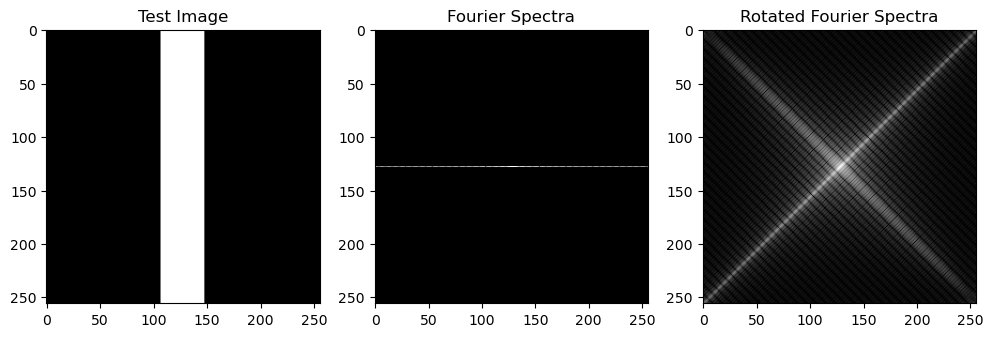

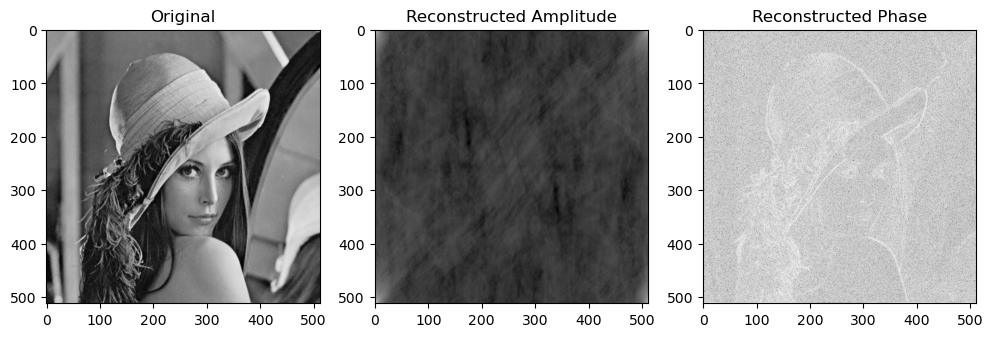

In [2]:
# Let us now study the characteristics of an image in frequency domain. For this study, we will create a new 256×256 test image, which consists of a white rectangle.

f = np.zeros((256,256))
f[:,107:148] = 1

# Now plot the Fourier spectra of the image. Be sure to use the cmap = ‘gray‘ argument in the plt.imshow funtion. The np.fft2, np.fftshift, and np.abs functions will be useful here.
F = np.fft.fftshift(np.fft.fft2(f))

# Now rotate the test image by 45 degrees and plot both the Fourier spectra and the image. use the skimage.transform.rotate function.
f_rot = rotate(f, 45)
F_rot = np.fft.fftshift(np.fft.fft2(f_rot))

# plot the two
plot_images({'Test Image': f, 'Fourier Spectra': np.log(1+abs(F)), 'Rotated Fourier Spectra': np.log(1+abs(F_rot))}, cmap='gray')

# Now let us study the contribution of Fourier amplitude and phase to the underlying image. Load the Lena image and convert it to a grayscale image using the skimage.color.rgb2gray function. (lena)

# Now compute the amplitude and phase of the Lena image. Remember that the amplitude component A is the magnitude of the Fourier complex component (use the np.abs function) and the phase component θ can be found by simply dividing the Fourier component F (w) by the amplitude A since F(w) = A ∗ (cos(θ) + j sin(θ))

F = np.fft.fftshift(np.fft.fft2(lena))
A = np.abs(F)
theta = np.angle(F)

fixed_phase = 0
fixed_amplitude = 1

# Now perform the inverse Fourier transform on the amplitude component A and the phase component θ separately. np.fft.ifft2 and np.fft.ifftshift will come in handy.
#  Plot the original image, the reconstructed image (lena) using just the amplitude component, and the reconstructed image using just the phase component.

fourier_component_amplitude = A*(np.cos(fixed_phase) + 1j*np.sin(fixed_phase))
lena_reconstructed_amplitude = np.fft.ifft2(np.fft.ifftshift(fourier_component_amplitude))

fourier_component_phase = fixed_amplitude*(np.cos(theta) + 1j*np.sin(theta))
lena_reconstructed_phase = np.fft.ifft2(np.fft.ifftshift(fourier_component_phase))

#plot

plot_images({'Original': lena, 'Reconstructed Amplitude': np.log(abs(lena_reconstructed_amplitude)), 'Reconstructed Phase': np.log(abs(lena_reconstructed_phase)) }, cmap='gray')



# Part 3: Noise Reduction in the Frequency Domain

# Part 4: Filter Design

[[  0   0]
 [138 152]
 [118 104]
 [ 64  64]
 [192 192]]


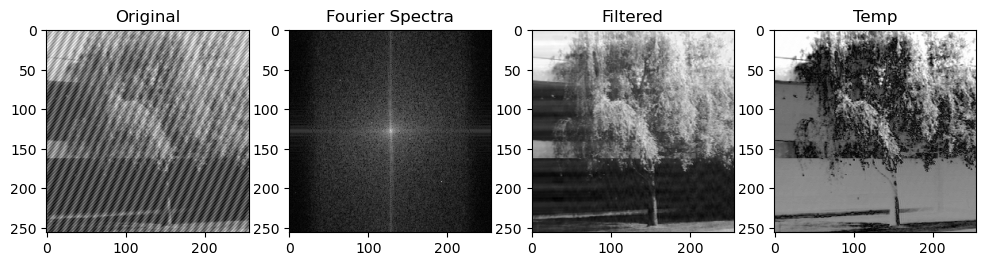

In [4]:
# Examine the frequnoisy image and its Fourier spectrum.

frequnoisy_fft = np.fft.fftshift(np.fft.fft2(frequnoisy))

# plot_images({'Original': frequnoisy, 'Fourier Spectra': np.log(1+abs(frequnoisy_fft))}, cmap='gray')

# Note the peaks in the spectrum corresponding to the periodic noise source, which has been added to the original image. Design and implement a frequency domain filter which filters out this noise. 

# Note that there are approximately four peaks in the Fourier spectrum. We can design a filter that removes these peaks by setting the values of the Fourier components corresponding to these peaks to zero.

# First, we need to find the coordinates of these peaks. Then, we can create a filter which is 1 everywhere except at the coordinates of the maximum value, where it is 0.

temp = np.copy(frequnoisy_fft)
#array of coordinates of top 4 coordinates
max_coords = np.zeros((4,2), dtype=int)

for i in range(4):
    max_index = np.unravel_index(np.argmax(temp, axis=None), temp.shape)
    temp[max_index] = 0
    max_coords[i] = max_index
    # need to flip the coordinates but also avoid removing the center peak

print(max_coords)  

# Now we can create a filter which is 1 everywhere except at the coordinates of the maximum value, where it is 0.

filter = np.ones(frequnoisy_fft.shape)
filter[max_coords] = 0

# Now we can apply this filter to the Fourier spectrum of the noisy image to obtain the filtered image.

frequnoisy_filtered = np.fft.ifft2(np.fft.ifftshift(frequnoisy_fft*filter))
temp_new = np.fft.ifft2(np.fft.ifftshift(temp))

# plot

plot_images({'Original': frequnoisy, 'Fourier Spectra': np.log(1+abs(frequnoisy_fft)), 'Filtered': np.log(1+abs(frequnoisy_filtered)), 'Temp': np.log(1+abs(temp_new)) }, cmap='gray')


# Now set the values of the Fourier components corresponding to these peaks to zero. Then perform the inverse Fourier transform to obtain the filtered image. Plot the original image, the Fourier spectrum, and the filtered image.

# frequnoisy_filtered = np.fft.ifft2(np.fft.ifftshift(frequnoisy_fft))

# plot_images({'Original': frequnoisy, 'Fourier Spectra': np.log(1+abs(frequnoisy_fft)), 'Filtered': np.log(1+abs(frequnoisy_filtered))}, cmap='gray')
